## Add Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image

import splitfolders
import os
import shutil
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

## Read In Data

In [3]:
df1 = pd.read_csv("data/pokedex.csv", index_col=0)
df1["image_address"] = df1["image"]
df1 = df1.drop(columns = "image")
df1

,dex_no,name,type1,type2,image_name,image_address
0,1,Bulbasaur,Grass,Poison,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
1,2,Ivysaur,Grass,Poison,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
2,3,Venusaur,Grass,Poison,venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
3,4,Charmander,Fire,NaN,charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...
4,5,Charmeleon,Fire,NaN,charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...
...,...,...,...,...,...,...
1005,1006,Iron Valiant,Fairy,Fighting,iron-valiant.png,https://img.pokemondb.net/sprites/scarlet-viol...
1006,1007,Koraidon,Fighting,Dragon,koraidon.png,https://img.pokemondb.net/sprites/scarlet-viol...
1007,1008,Miraidon,Electric,Dragon,miraidon.png,https://img.pokemondb.net/sprites/scarlet-viol...
1008,1009,Walking Wake,Water,Dragon,walking-wake.png,https://img.pokemondb.net/sprites/scarlet-viol...


In [4]:
df2 = pd.read_csv("data/pokedex4.csv", index_col=0)
df2

,image_address,image_name,name,type1,type2
0,archives.bulbagarden.net/media/upload/thumb/f/...,2Bulbasaur.png,Bulbasaur,Grass,Poison
1,archives.bulbagarden.net/media/upload/thumb/8/...,2Ivysaur.png,Ivysaur,Grass,Poison
2,archives.bulbagarden.net/media/upload/thumb/6/...,2Venusaur.png,Venusaur,Grass,Poison
3,archives.bulbagarden.net/media/upload/thumb/2/...,2Charmander.png,Charmander,Fire,NaN
4,archives.bulbagarden.net/media/upload/thumb/0/...,2Charmeleon.png,Charmeleon,Fire,NaN
...,...,...,...,...,...
1150,archives.bulbagarden.net/media/upload/thumb/2/...,2Iron_Valiant.png,Iron_Valiant,Fairy,Fighting
1151,archives.bulbagarden.net/media/upload/thumb/a/...,2Koraidon.png,Koraidon,Fighting,Dragon
1152,archives.bulbagarden.net/media/upload/thumb/1/...,2Miraidon.png,Miraidon,Electric,Dragon
1153,archives.bulbagarden.net/media/upload/thumb/b/...,2Walking_Wake.png,Walking_Wake,Water,Dragon


In [5]:
df = pd.concat([df1, df2])
df

,dex_no,name,type1,type2,image_name,image_address
0,1.0,Bulbasaur,Grass,Poison,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
1,2.0,Ivysaur,Grass,Poison,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
2,3.0,Venusaur,Grass,Poison,venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...
3,4.0,Charmander,Fire,NaN,charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...
4,5.0,Charmeleon,Fire,NaN,charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...
...,...,...,...,...,...,...
1150,NaN,Iron_Valiant,Fairy,Fighting,2Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...
1151,NaN,Koraidon,Fighting,Dragon,2Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...
1152,NaN,Miraidon,Electric,Dragon,2Miraidon.png,archives.bulbagarden.net/media/upload/thumb/1/...
1153,NaN,Walking_Wake,Water,Dragon,2Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...


In [6]:
df['types'] = df.apply(lambda x: [x['type1'], x['type2']], axis=1)
df = df.drop(columns = ["dex_no", "type1", "type2"])

In [7]:
df = df.explode('types')

In [8]:
df

,name,image_name,image_address,types
0,Bulbasaur,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
0,Bulbasaur,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Poison
1,Ivysaur,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
1,Ivysaur,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Poison
2,Venusaur,venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
...,...,...,...,...
1152,Miraidon,2Miraidon.png,archives.bulbagarden.net/media/upload/thumb/1/...,Dragon
1153,Walking_Wake,2Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...,Water
1153,Walking_Wake,2Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...,Dragon
1154,Iron_Leaves,2Iron_Leaves.png,archives.bulbagarden.net/media/upload/thumb/8/...,Grass


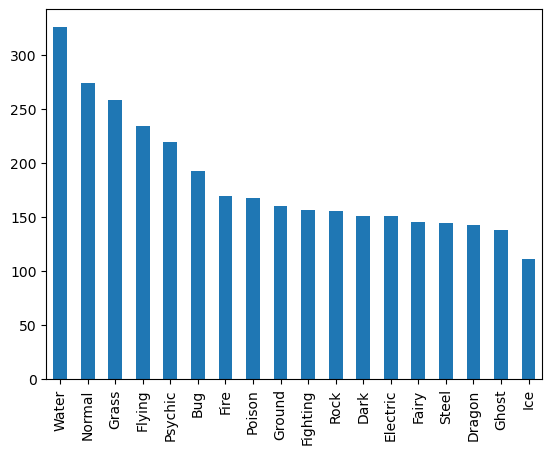

In [9]:
df.types.value_counts().plot(kind='bar');

In [12]:
df.types.value_counts().head(11)

Water       326
Normal      274
Grass       258
Flying      234
Psychic     219
Bug         192
Fire        169
Poison      167
Ground      160
Fighting    156
Rock        155
Name: types, dtype: int64

In [14]:
main_types = ["Water", "Normal", "Grass", "Flying", "Pyschic", "Bug", "Fire", "Poison", "Ground", "Fighting", "Rock"]

In [15]:
len(main_types)

11

In [16]:
df_reduced = df[df['types'].isin(main_types)]

In [17]:
df_reduced

,name,image_name,image_address,types
0,Bulbasaur,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
0,Bulbasaur,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Poison
1,Ivysaur,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
1,Ivysaur,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Poison
2,Venusaur,venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
...,...,...,...,...
1148,Chi-Yu,2Chi-Yu.png,archives.bulbagarden.net/media/upload/thumb/7/...,Fire
1150,Iron_Valiant,2Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...,Fighting
1151,Koraidon,2Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...,Fighting
1153,Walking_Wake,2Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...,Water


In [18]:
df_further_reduced = df_reduced.drop_duplicates(subset=["name", "image_name"])
df_further_reduced

,name,image_name,image_address,types
0,Bulbasaur,bulbasaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
1,Ivysaur,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
2,Venusaur,venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass
3,Charmander,charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...,Fire
4,Charmeleon,charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...,Fire
...,...,...,...,...
1148,Chi-Yu,2Chi-Yu.png,archives.bulbagarden.net/media/upload/thumb/7/...,Fire
1150,Iron_Valiant,2Iron_Valiant.png,archives.bulbagarden.net/media/upload/thumb/2/...,Fighting
1151,Koraidon,2Koraidon.png,archives.bulbagarden.net/media/upload/thumb/a/...,Fighting
1153,Walking_Wake,2Walking_Wake.png,archives.bulbagarden.net/media/upload/thumb/b/...,Water


In [19]:
os.listdir("data/images/")

['2Wooper.png',
 'Tangela_Tangela29.jpg',
 'Slowpoke_Slowpoke12.jpg',
 'Mankey_Mankey9.jpg',
 '2Charmeleon.png',
 'Vaporeon_Vaporeon19.jpg',
 '2Silvally.png',
 'Onix_Onix7.jpg',
 '2Tinkatuff.png',
 'staraptor.jpg',
 '2Mesprit.png',
 'taillow.jpg',
 '2Marowak.png',
 '2Litten.png',
 'Charizard_Charizard17.jpg',
 'charizard.jpg',
 'Tangela_Tangela15.jpg',
 'Vaporeon_Vaporeon31.jpg',
 'infernape.jpg',
 'Beedrill_Beedrill3.jpg',
 'Vaporeon_Vaporeon25.jpg',
 'morgrem.jpg',
 'pidove.jpg',
 'comfey.jpg',
 'Flareon_Flareon13.jpg',
 'pawmi.png',
 'bulbasaur.jpg',
 '2Groudon.png',
 '2Glimmora.png',
 '2Ribombee.png',
 'Exeggutor_Exeggutor10.jpg',
 '2Delphox.png',
 'Tentacruel_Tentacruel5.jpg',
 'banette.jpg',
 '2Golett.png',
 'Cubone_Cubone16.jpg',
 'Metapod_Metapod3.jpg',
 '2Giratina-Origin.png',
 'articuno.jpg',
 '2Igglybuff.png',
 'Starmie_Starmie28.jpg',
 'Magikarp_Magikarp11.jpg',
 'Lickitung_Lickitung21.jpg',
 'pyroar.jpg',
 'Jigglypuff_Jigglypuff19.jpg',
 '2Keldeo.png',
 '2Tinkatink.png',
 

In [20]:
df_4 = pd.DataFrame(os.listdir("data/images/"))

In [27]:
df_4.columns

RangeIndex(start=0, stop=1, step=1)

In [29]:
df_4.columns = "image_name"

TypeError: Index(...) must be called with a collection of some kind, 'image_name' was passed

In [22]:
df_4 = df_4.loc[~df_4["0"].startswith("2")]

KeyError: '0'

In [ ]:
for image in os.listdir("data/images/"):
    if image.str.contains()

## Split Folders for Train-Test and By Class

In [15]:
# create train-test-validation folders
splitfolders.ratio('data', output="train_test_folders", seed=1337, ratio=(.8, 0.0, 0.2)) 

# add images to folders
train_list = []
for image in os.listdir("train_test_folders/train/images"):
    train_list.append(image)
    
test_list = []
for image in os.listdir("train_test_folders/test/images"):
    test_list.append(image)

    
# note in dataframe which folder image is in
train_df = df_further_reduced.loc[df_further_reduced.apply(lambda row: row["image_name"] in train_list, axis=1)]
test_df = df_further_reduced.loc[df_further_reduced.apply(lambda row: row["image_name"] in test_list, axis=1)]

train_df["split"] = "train"
test_df["split"] = "test"

pdList = [train_df, test_df]
df_tts = pd.concat(pdList)
df_tts

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_28893/3579784355.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["split"] = "train"
/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_28893/3579784355.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["split"] = "test"


,name,image_name,image_address,types,split
1,Ivysaur,ivysaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass,train
2,Venusaur,venusaur.jpg,https://img.pokemondb.net/sprites/home/normal/...,Grass,train
3,Charmander,charmander.jpg,https://img.pokemondb.net/sprites/home/normal/...,Fire,train
4,Charmeleon,charmeleon.jpg,https://img.pokemondb.net/sprites/home/normal/...,Fire,train
5,Charizard,charizard.jpg,https://img.pokemondb.net/sprites/home/normal/...,Fire,train
...,...,...,...,...,...
1107,Revavroom,2Revavroom.png,archives.bulbagarden.net/media/upload/thumb/1/...,Poison,test
1111,Glimmora,2Glimmora.png,archives.bulbagarden.net/media/upload/thumb/d/...,Rock,test
1114,Flamigo,2Flamigo.png,archives.bulbagarden.net/media/upload/thumb/0/...,Flying,test
1123,Clodsire,2Clodsire.png,archives.bulbagarden.net/media/upload/thumb/7/...,Poison,test


In [16]:
# add class folders and organize images
train_dir = 'train_test_folders/train/images'
test_dir = 'train_test_folders/test/images'

for index, row in df_tts.iterrows():
    class_label = row['types']  
    filename = row['image_name']  
    if class_label not in os.listdir(train_dir):
        os.mkdir(os.path.join(train_dir, class_label))
    if class_label not in os.listdir(test_dir):
        os.mkdir(os.path.join(test_dir, class_label))     
    if row['split'] == 'train':
        shutil.move(os.path.join(train_dir, filename), os.path.join(train_dir, class_label, filename))
    elif row['split'] == 'test':
        shutil.move(os.path.join(test_dir, filename), os.path.join(test_dir, class_label, filename))

In [17]:
# create generators
train_path = "train_test_folders/train/images"
test_path = "train_test_folders/test/images"

data_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

train_generator = data_gen.flow_from_directory(train_path, target_size = (224, 224), color_mode ='rgb', 
                                                    batch_size = 32, class_mode='categorical')

test_generator = data_gen.flow_from_directory(test_path, target_size = (224, 224), color_mode ='rgb',
                                              batch_size = 32, class_mode='categorical')

Found 1311 images belonging to 10 classes.
Found 325 images belonging to 10 classes.


## Base Model

In [18]:
reg = l2(3e-3)
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))

Metal device set to: Apple M1 Pro


2023-03-27 19:50:13.134336: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 19:50:13.134471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [34]:
cce = tf.keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.01)
num_of_train_samples = 1311
num_of_test_samples = 325
batch_size = 32
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

In [20]:
base_model = model.fit(
        train_generator, verbose = 1, 
        validation_data = test_generator, 
        epochs=100)

Epoch 1/100


2023-03-27 19:50:13.315281: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-27 19:50:13.497342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/41 [========================>.....] - ETA: 2s - loss: 77.2225 - accuracy: 0.1600

/opt/homebrew/Caskroom/miniforge/base/envs/middle-earth/lib/python3.8/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 [==============================] - ETA: 0s - loss: 71.8528 - accuracy: 0.1670

2023-03-27 19:50:30.219227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 20s 489ms/step - loss: 71.8528 - accuracy: 0.1670 - val_loss: 36.8438 - val_accuracy: 0.1538
Epoch 2/100
41/41 [==============================] - 20s 486ms/step - loss: 22.2105 - accuracy: 0.1846 - val_loss: 12.1556 - val_accuracy: 0.1538
Epoch 3/100
41/41 [==============================] - 20s 484ms/step - loss: 8.1333 - accuracy: 0.1846 - val_loss: 5.3945 - val_accuracy: 0.1538
Epoch 4/100
41/41 [==============================] - 20s 483ms/step - loss: 4.1852 - accuracy: 0.1846 - val_loss: 3.3805 - val_accuracy: 0.1538
Epoch 5/100
41/41 [==============================] - 20s 484ms/step - loss: 2.9688 - accuracy: 0.1846 - val_loss: 2.7367 - val_accuracy: 0.1538
Epoch 6/100
41/41 [==============================] - 20s 485ms/step - loss: 2.5724 - accuracy: 0.1846 - val_loss: 2.5194 - val_accuracy: 0.1538
Epoch 7/100
41/41 [==============================] - 20s 483ms/step - loss: 2.4439 - accuracy: 0.1846 - val_loss: 2.4614 - val_accuracy: 0.1538


Epoch 58/100
41/41 [==============================] - 20s 485ms/step - loss: 2.3005 - accuracy: 0.1846 - val_loss: 2.3302 - val_accuracy: 0.1538
Epoch 59/100
41/41 [==============================] - 20s 486ms/step - loss: 2.2838 - accuracy: 0.1846 - val_loss: 2.3245 - val_accuracy: 0.1538
Epoch 60/100
41/41 [==============================] - 20s 487ms/step - loss: 2.2813 - accuracy: 0.1846 - val_loss: 2.3244 - val_accuracy: 0.1538
Epoch 61/100
41/41 [==============================] - 20s 487ms/step - loss: 2.2820 - accuracy: 0.1846 - val_loss: 2.3240 - val_accuracy: 0.1538
Epoch 62/100
41/41 [==============================] - 20s 484ms/step - loss: 2.2806 - accuracy: 0.1846 - val_loss: 2.3225 - val_accuracy: 0.1538
Epoch 63/100
41/41 [==============================] - 20s 486ms/step - loss: 2.2792 - accuracy: 0.1846 - val_loss: 2.3232 - val_accuracy: 0.1538
Epoch 64/100
41/41 [==============================] - 20s 489ms/step - loss: 2.2790 - accuracy: 0.1846 - val_loss: 2.3192 - val_ac

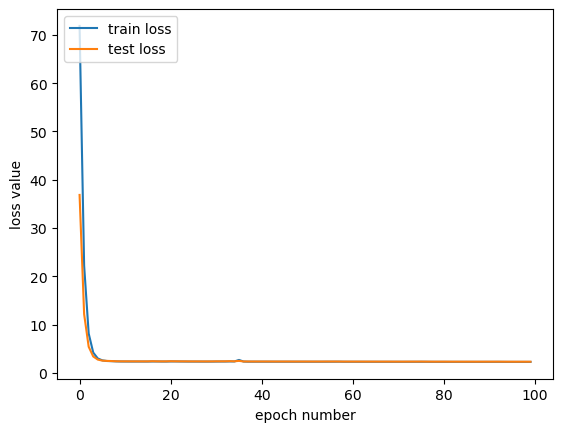

In [21]:
plt.plot(base_model.history["loss"], label = "train loss");
plt.plot(base_model.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

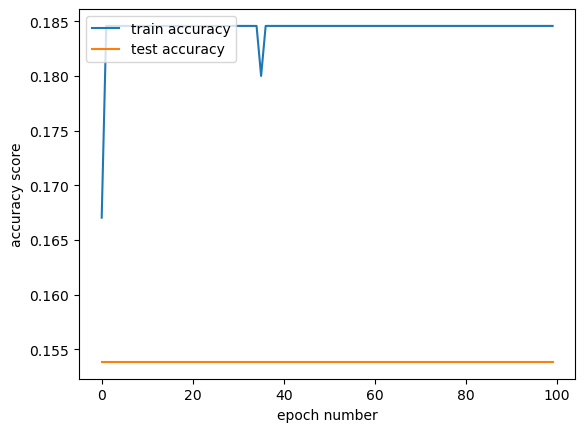

In [22]:
plt.plot(base_model.history["accuracy"], label = "train accuracy");
plt.plot(base_model.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

In [38]:
X_train, y_train = next(train_generator)
X_test, y_test = next(test_generator)

In [43]:
X_test

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [36]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator, 
                                 num_of_test_samples // batch_size+1)

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

/var/folders/x7/5j65n6x57hq9g5yst5z9k1m00000gn/T/ipykernel_28893/3687381743.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator,


Confusion Matrix
[[ 0  0  0  0  0  0  0  0  0 32]
 [ 0  0  0  0  0  0  0  0  0 17]
 [ 0  0  0  0  0  0  0  0  0 32]
 [ 0  0  0  0  0  0  0  0  0 23]
 [ 0  0  0  0  0  0  0  0  0 46]
 [ 0  0  0  0  0  0  0  0  0 21]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0  0  0 50]]


In [47]:
y_proba = model.predict(X_test)

1/1 [==============================] - 0s 16ms/step


In [49]:
cm_digits = confusion_matrix(y_test, y_proba)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_digits)

disp.plot(cmap=plt.cm.Blues)
plt.show()

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

## Model 2

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
model_2 = model.fit(
        train_generator, steps_per_epoch = 2,
        verbose = 1, validation_data = test_generator, 
        epochs = 100)

In [ ]:
plt.plot(model_2.history["loss"], label = "train loss");
plt.plot(model_2.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
plt.plot(model_2.history["accuracy"], label = "train accuracy");
plt.plot(model_2.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 3

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))

model.add(Dropout(0.2))

model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))

model.add(Dropout(0.1))

model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_3 = model.fit(
        train_generator, steps_per_epoch = 2,
        verbose=1, validation_data = test_generator, 
        epochs=100)

In [ ]:
plt.plot(model_3.history["loss"], label = "train loss");
plt.plot(model_3.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
plt.plot(model_3.history["accuracy"], label = "train accuracy");
plt.plot(model_3.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 4

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(64, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(32, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(16, activation='relu', kernel_regularizer = reg))
model.add(Dense(10, activation='softmax', kernel_regularizer = reg))
model.compile(optimizer='adam', loss=bce,  metrics=['accuracy'])
model_4 = model.fit(
        train_generator, steps_per_epoch = 2, validation_data = test_generator, 
        epochs=100)

In [ ]:
plt.plot(model_4.history["loss"], label = "train loss");
plt.plot(model_4.history["val_loss"], label = "test loss")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("loss value");

In [ ]:
plt.plot(model_4.history["accuracy"], label = "train accuracy");
plt.plot(model_4.history["val_accuracy"], label = "test accuracy")
plt.legend(loc = "upper left")
plt.xlabel("epoch number")
plt.ylabel("accuracy score");

## Model 5